In [37]:
#import libs
from pathlib import Path
import pandas as pd
import numpy as np
import zipfile
import urllib.request

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
#DL and read data
def load_extract_dataset():
    zip_path = Path("datasets/usedcars.zip")
    if not zip_path.is_file():
        if not Path("datasets").exists():
            Path("datasets").mkdir(parents=True , exist_ok=True)
        url = "https://www.kaggle.com/api/v1/datasets/download/nehalbirla/vehicle-dataset-from-cardekho"
        urllib.request.urlretrieve(url , zip_path)
        with zipfile.ZipFile(zip_path) as usedcars_zip:
            usedcars_zip.extractall(path="datasets/usedcars")
    return 0 #pd.read_csv(Path("datasets/usedcars/used cars.csv"))

In [3]:
load_extract_dataset()
used_cars = pd.read_csv(Path("datasets/usedcars/CAR DETAILS FROM CAR DEKHO.csv"))
used_cars_v3 = pd.read_csv(Path("datasets/usedcars/Car details v3.csv"))
used_cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [4]:
#dropping col "name". Not required for selling price estimation
used_cars.drop("name" , axis=1 , inplace=True)

In [5]:
#using 'age' instead of 'manufacture year'
used_cars["age"] = 2026 - used_cars["year"]
used_cars.drop("year" , axis=1 , inplace=True)

In [6]:
used_cars["fuel"].value_counts()

fuel
Diesel      2153
Petrol      2123
CNG           40
LPG           23
Electric       1
Name: count, dtype: int64

In [7]:
used_cars["seller_type"].value_counts()

seller_type
Individual          3244
Dealer               994
Trustmark Dealer     102
Name: count, dtype: int64

In [8]:
used_cars["transmission"].value_counts()

transmission
Manual       3892
Automatic     448
Name: count, dtype: int64

In [9]:
used_cars["owner"].value_counts()

owner
First Owner             2832
Second Owner            1106
Third Owner              304
Fourth & Above Owner      81
Test Drive Car            17
Name: count, dtype: int64

In [10]:
used_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   selling_price  4340 non-null   int64 
 1   km_driven      4340 non-null   int64 
 2   fuel           4340 non-null   object
 3   seller_type    4340 non-null   object
 4   transmission   4340 non-null   object
 5   owner          4340 non-null   object
 6   age            4340 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 237.5+ KB


In [11]:
used_cars.describe()

,selling_price,km_driven,age
count,4.340000e+03,4340.000000,4340.000000
mean,5.041273e+05,66215.777419,12.909217
std,5.785487e+05,46644.102194,4.215344
min,2.000000e+04,1.000000,6.000000
25%,2.087498e+05,35000.000000,10.000000
50%,3.500000e+05,60000.000000,12.000000
75%,6.000000e+05,90000.000000,15.000000
max,8.900000e+06,806599.000000,34.000000


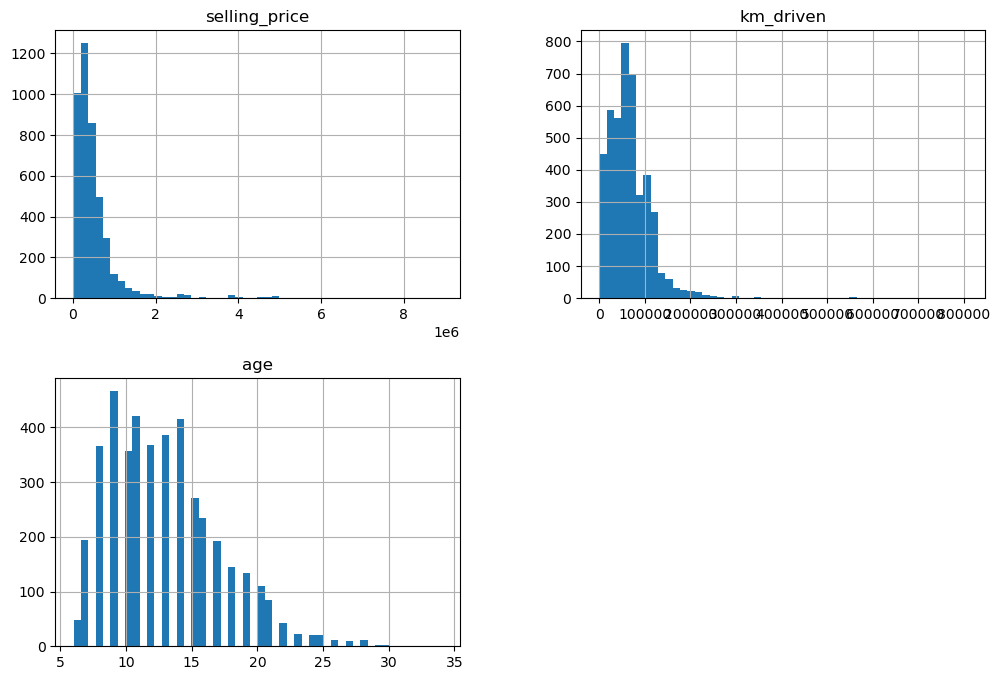

In [12]:
used_cars.hist(bins=50,figsize=(12,8))
plt.show()

In [13]:
#looking for correlations
corr_matrix = used_cars.corr(numeric_only=True)

#what is correlated with the selling price?
corr_matrix["selling_price"].sort_values(ascending=False) 
#conclusion: 
#    age rising => selling price tend to fall
#    km_driven rising => selling price tend to fall slightly

selling_price    1.000000
km_driven       -0.192289
age             -0.413922
Name: selling_price, dtype: float64

In [14]:
#convert categorial features to numerical
#could use used_cars = pd.get_dummies(data = used_cars , drop_first=True) but will create a cat_pipeline instead

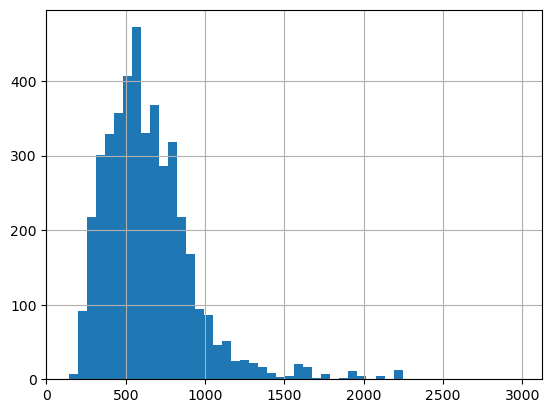

In [15]:
#try to break the concentration of values on the left
sqrt_transf = FunctionTransformer(np.sqrt , inverse_func=np.square)
transf_kms_driven = sqrt_transf.transform(used_cars["selling_price"])
transf_kms_driven.hist(bins=50)
plt.show()

# => success! but we must use the inverse_transform() method to get the correct prediction later!

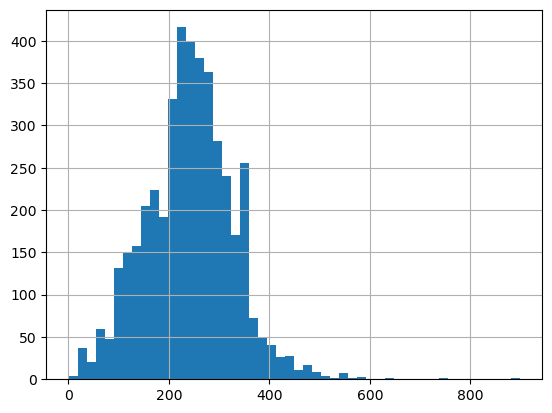

In [16]:
#try  to break concentration of values on th left for "km_driven"
km_driven_transf_sqrt = sqrt_transf.transform(used_cars["km_driven"])

km_driven_transf_sqrt.hist(bins=50)
plt.show()

# => success! sqrt transformation works better then log-transform

In [17]:
#separating feature set from label set
X = used_cars.drop("selling_price" , axis=1)
y = used_cars["selling_price"].copy()

In [18]:
#split into train and test set
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

print("X train set shape: ",X_train.shape)
print("X test set shape: ",X_test.shape)
print("y train set shape: ",y_train.shape)
print("y test set shape: ",y_test.shape)

X train set shape:  (3472, 6)
X test set shape:  (868, 6)
y train set shape:  (3472,)
y test set shape:  (868,)


In [19]:
#prepare pipelines

#for non-numerical/categories features
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                            OneHotEncoder(handle_unknown="ignore"))

#for label and km_driven
sqrt_pipeline = make_pipeline(FunctionTransformer(np.sqrt , inverse_func=np.square , feature_names_out="one-to-one"),
                              StandardScaler())

scaling_pipeline = make_pipeline(StandardScaler())

In [28]:
#assembling preprocessing pipeline
preprocessing_features = ColumnTransformer([
    ("scaler" , scaling_pipeline , ["age"]),
    ("sqrt" , sqrt_pipeline , ["km_driven"]),
    ("cat" , cat_pipeline , ["fuel" , "transmission" , "owner"])
])

preprocessing_label = Pipeline([
    ("sqrt" , sqrt_pipeline)
])

In [29]:
# just for doublecheck matrix shape (will not used)
used_cars_prep = preprocessing_features.fit_transform(used_cars)
print("Shape: " + str(used_cars_prep.shape))
preprocessing_features.get_feature_names_out()
#Final shape for the regressor:

Shape: (4340, 14)


array(['scaler__age', 'sqrt__km_driven', 'cat__fuel_CNG',
       'cat__fuel_Diesel', 'cat__fuel_Electric', 'cat__fuel_LPG',
       'cat__fuel_Petrol', 'cat__transmission_Automatic',
       'cat__transmission_Manual', 'cat__owner_First Owner',
       'cat__owner_Fourth & Above Owner', 'cat__owner_Second Owner',
       'cat__owner_Test Drive Car', 'cat__owner_Third Owner'],
      dtype=object)

========================

In [44]:
#try different regression models: 1) Linear Regression
from sklearn.linear_model import LinearRegression

#putting all together into regression model
#with TransformedTargetRegressor predictions are automatically squared and un-scaled back
lin_reg_model = TransformedTargetRegressor(
    regressor=Pipeline([
        ("features", preprocessing_features),
        ("model", LinearRegression())
    ]),
    transformer=preprocessing_label
)

lin_reg_model.fit(X_train , y_train)

y_train_pred = lin_reg_model.predict(X_train)

# possible printouts of the first 5 values:
#y_pred[:5].round(-2) #round to the nearest hundred
#y_train.iloc[:5].values

In [61]:
ln_train_rmse = root_mean_squared_error(y_train , y_train_pred)
print("Prediction error on train data: " + str(ln_train_rmse.round(2)))

Prediction error on train data: 412152.4


In [60]:
y_test_pred = lin_reg_model.predict(X_test)
ln_test_rmse = root_mean_squared_error(y_test , y_test_pred)
print("Prediction error on test data: " + str(ln_test_rmse.round(2)))

Prediction error on test data: 415732.67


In [63]:
#cross-validation score:
ln_train_rmses = -cross_val_score(lin_reg_model , X_train , y_train , scoring="neg_root_mean_squared_error" , cv=5)
cv_mean = ln_train_rmses.mean()

print("Train CV score: " + str(ln_train_rmses.round(2)))
print("CV mean: " + str(cv_mean.round(2)))

Train CV score: [404018.74 383391.09 405219.62 393520.53 467140.2 ]
CV mean: 410658.04
